### PREPROCESSING
--> data combi??
… merging datasets + labelinng (classes (no)wildfire)
--> reseizing/normalizing (gleiche Auflösung + scaling pixel values)
--> ggf. augmentation
--> train/test/split

### MODELLING
Custom vs. Pretrained model
--> Conv2D + ReLU
(BEISPIELNOTEBOOK: Conv2D → ReLU → MaxPooling → BatchNorm → Dropout.
Dense layers at the end for binary classification.)
--> LSTM?
(LSTM to process sequences of extracted features.)

### TRAINING
Classification: Binary Crossentropy Loss


# Trying RandomForest Classification with wildfire

In [5]:
import os
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score


In [6]:
# Define paths
base_path = "../raw_data/wildfire_images_2_classes/"
train_path = os.path.join(base_path, "train")
valid_path = os.path.join(base_path, "valid")
wildfire_path = os.path.join(base_path, "train/wildfire/")
nowildfire_path = os.path.join(base_path, "train/nowildfire/")

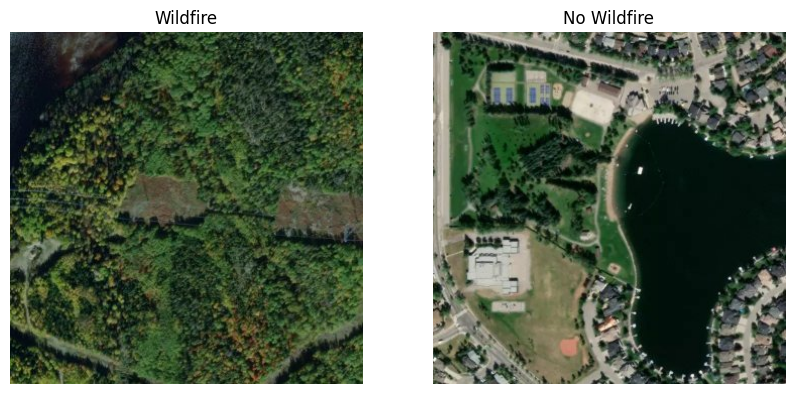

In [7]:
# Showing random images from both classes
def display_random_images():
    wildfire_img = random.choice(os.listdir(wildfire_path))
    nowildfire_img = random.choice(os.listdir(nowildfire_path))

    wildfire_img_path = os.path.join(wildfire_path, wildfire_img)
    nowildfire_img_path = os.path.join(nowildfire_path, nowildfire_img)

    # Load and display images
    wildfire = load_img(wildfire_img_path)
    nowildfire = load_img(nowildfire_img_path)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Wildfire")
    plt.imshow(wildfire)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("No Wildfire")
    plt.imshow(nowildfire)
    plt.axis("off")

    plt.show()
    
# Display random images
display_random_images()


In [8]:
# Applying Gabor filter
def apply_gabor_filter(img):
    # Converting to grayscale
    if len(img.shape) == 3:  # Checking for multiple image channels (RGB)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Applying Gabor filters for edge/texture extraction
    gabor_kernels = []
    for theta in [0, np.pi/4, np.pi/2, 3*np.pi/4]:  # orientations
        gabor_kernels.append(cv2.getGaborKernel((5, 5), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F))
    filtered_imgs = [cv2.filter2D(img, cv2.CV_32F, kernel) for kernel in gabor_kernels]

    # Combining filtered images
    return np.mean(filtered_imgs, axis=0)


In [9]:
# PREPROCESSING images

IMG_SIZE = (128, 128)  # Resizing

def preprocess_images(folder_path):
    images = []
    labels = []
    for label, class_name in enumerate(["wildfire", "nowildfire"]):
        class_path = os.path.join(folder_path, class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            try:
                # Loading + preprocessing image
                img = load_img(image_path, target_size=IMG_SIZE)  # Resizing
                img_array = img_to_array(img)  # Converting -> numpy array
                img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)  # Converting -> grayscale (needed by gabor)
                img_array = img_array / 255.0  # Normalizing
                img_array = apply_gabor_filter(img_array)  # Applying Gaborfilter
                images.append(img_array.flatten())  # Flattening
                labels.append(label)  # Labelx: 0 = No Wildfire, 1 = Wildfire
            except OSError as e:
                print(f"Skipped image: {image_path}. Error: {e}")
                continue 
    return np.array(images), np.array(labels)

In [10]:
# PREPROCESSING train + valid DS
X_train, y_train = preprocess_images(train_path)
X_valid, y_valid = preprocess_images(valid_path)

Skipped image: ../raw_data/wildfire_images_2_classes/train/nowildfire/-114.152378,51.027198.jpg. Error: image file is truncated (16 bytes not processed)


In [14]:
X_train.shape

(30249, 16384)

In [15]:
# Converting X_train to DataFrame for insighst
X_train_df = pd.DataFrame(X_train)
y_train_df = pd.Series(y_train, name="Label")

In [16]:
X_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30249 entries, 0 to 30248
Columns: 16384 entries, 0 to 16383
dtypes: float32(16384)
memory usage: 1.8 GB


In [17]:
# INITIALIZING Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,  # Tree Numb
    max_depth=20,      # Max tree depth 
    random_state=42,   
    n_jobs=-1          # Using all CPU cores for parallel training
)

In [18]:
# TRAINING model
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_jobs=-1, random_state=42)

In [19]:
# EVALUATING model
y_pred = rf_model.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)

print(f"Validation Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_valid, y_pred, target_names=["No Wildfire", "Wildfire"]))

Validation Accuracy: 0.88

Classification Report:
              precision    recall  f1-score   support

 No Wildfire       0.90      0.89      0.89      3480
    Wildfire       0.86      0.87      0.87      2820

    accuracy                           0.88      6300
   macro avg       0.88      0.88      0.88      6300
weighted avg       0.88      0.88      0.88      6300



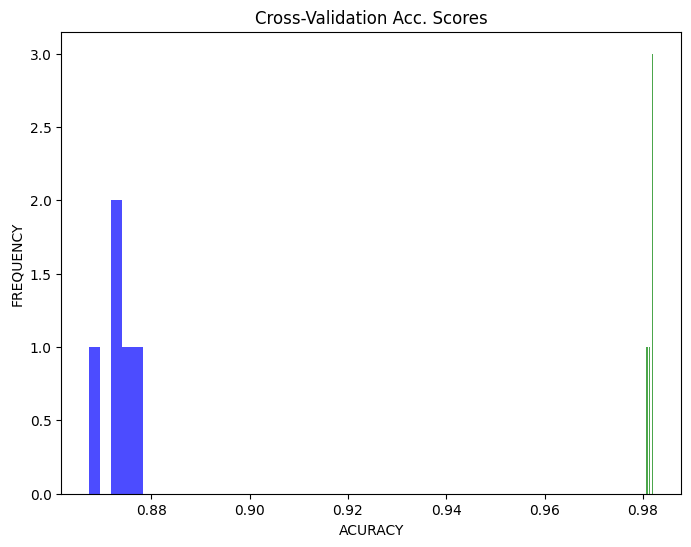

In [20]:
# CV Random Forest
cv_results = cross_validate(
    rf_model,              
    X_train,               
    y_train,               
    scoring="accuracy",   
    cv=5,                  
    return_train_score=True
)

# CV results
def plot_histogram_cv_results(cv_results):
    plt.figure(figsize=(8, 6))
    plt.hist(cv_results["test_score"], bins=5, alpha=0.7, color="blue", label="Test Score")
    plt.hist(cv_results["train_score"], bins=5, alpha=0.7, color="green", label="Train Score")
    plt.title("Cross-Validation Acc. Scores")
    plt.xlabel("ACURACY")
    plt.ylabel("FREQUENCY")

# Plotting cv-results
plot_histogram_cv_results(cv_results)

In [21]:
# Printing cv-results
print(f"Mean Test Accuracy: {np.mean(cv_results['test_score']):.2f}")
print(f"Mean Train Accuracy: {np.mean(cv_results['train_score']):.2f}")

Mean Test Accuracy: 0.87
Mean Train Accuracy: 0.98


In [23]:
# BAGGING
bagging_model = BaggingClassifier(
    estimator=RandomForestClassifier(
        n_estimators=50,
        max_depth=15,
        random_state=42),
    n_estimators=10, 
    random_state=42,
    n_jobs=-1, 
)

# Traininf  + evaluating Bagging Classifier
bagging_model.fit(X_train, y_train)
bagging_cv_scores = cross_val_score(bagging_model,
                                    X_train,
                                    y_train,
                                    cv=5,
                                    scoring="accuracy")
print(f"Bagging Classifier Mean Accuracy: {np.mean(bagging_cv_scores):.2f}")

Bagging Classifier Mean Accuracy: 0.87


In [ ]:
# BOOSTING
from sklearn.tree import DecisionTreeClassifier

ada_boost_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=50, 
    learning_rate=1.0, 
    random_state=42
)

# Training AdaBoost model
ada_boost_model.fit(X_train, y_train)

# Evaluating + CV AdaBoost model
ada_boost_cv_scores = cross_val_score(
    ada_boost_model,
    X_train,
    y_train,
    cv=5,
    scoring="accuracy"
)

# PrintinG mean accuracy
print(f"AdaBoost Classifier Mean Accuracy: {np.mean(ada_boost_cv_scores):.2f}")

In [ ]:
# COMPARNG:
print(f"Random Forest Mean Accuracy: {np.mean(cv_results['test_score']):.2f}")
print(f"Bagging Classifier Mean Accuracy: {np.mean(bagging_cv_scores):.2f}")
print(f"AdaBoost Classifier Mean Accuracy: {np.mean(ada_boost_cv_scores):.2f}")